# Pre-processing & Classification Try-Outs

Here we try out different datasets we compiled, normalizers and classifiers that are available and try to determine the best combination.

## Datasets

Name | Description | Pixel Count Grid Size | Automatic Feature Selection | Better Hole Detection | File
--- | --- | --- | --- | --- | ---
Full | All (at that time) features, not cleaned. | 4 | N | N | `dataset.csv`
Cleaned | Most features (manually chosen). | 4 | N | N | `dataset-clean-manual.csv`
Cleaned+Extended | Most features and with more detail pixel count. | 8 | N | N | `dataset-clean-matrix.csv`
Cleaned+CleanExtended | Most features but with empy pixel counts removed. | 8 | N | N | `dataset-clean-clean-matrix.csv`
v4 | ? | 8 | N | N | `dataset-v4.csv`
v5 | Mixed with resized MNIST dataset. | 8 | N | N | `mnist.csv`
v6 | Uses automatic feature selection. | 8 | Y | N | `dataset-v6.csv`
v7 | All features (including blob width), automatic feature selection. | 8 | Y | Y | `dataset-v7.csv`
v8 | Includes all features and better hole detection. | 8 | N | Y | `dataset-v8.csv`

## Normalizers

- MinMax
- Robust
- QuartileTransformed

## Classifier

rank | classifier | options | dataset | score
--- | --- | --- | --- | ---
1 | SVM/C | `{'kernel': 'rbf', 'C': 3.75, 'gamma': 0.10}` | v8 | `0.987630208333`
2 | SVM/C | `{'kernel': 'rbf', 'C': 3.85, 'gamma': 0.10}` | v7 | `0.986328125000`
3 | SVM/C | `{'kernel': 'rbf', 'C': 3.70, 'gamma': 0.15}` | v6 | `0.984375000000`
4 | SVM/C | `{'kernel': 'rbf', 'C': 3.65, 'gamma': 0.15}` | Cleaned+Extended+MinMaxScaled | `0.980468750000`
5 | SVM/C | `{'kernel': 'rbf', 'C': 2.55, 'gamma': 0.15}` | v4 | `0.977864583333`
6 | kNN | `{'n_neighbors': 3}` | v8 | `0.973958333333`
7 | kNN | `{'n_neighbors': 4}` | v7 | `0.970703125000`
8 | kNN | `{'n_neighbors': 3}` | v6 | `0.968750000000`
9 | kNN | `{'n_neighbors': 3}` | Cleaned+Extended+MinMaxScaled | `0.967447916667`
10 | kNN | `{'n_neighbors': 5}` | v4 | `0.964192708333`
11 | SVM/C | `{'kernel': 'rbf', 'C': 3.80, 'gamma': 0.95}` | Cleaned+MinMaxScaled | `0.962890625000`
12 | kNN | `{'n_neighbors': 3}` | Cleaned+MinMaxScaled | `0.945312500000`

Source: `classifiers/results_20181110151634_20_0.csv` (Train test split 20%, random state `0`)

- SVM/C
- kNN
- RandomForest
- AdaBoost
- SGD

## Winner

Classifier SVM/C `kernel='rbf', C=3.75, gamma=0.1` with dataset v8.

In [41]:
# IMPORTS AND NOTEBOOK SETUP
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm

# Helpers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# Confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
# IMPORTING OUR DATASET
data_full = pd.read_csv('../dataset-numpy/dataset.csv')
data_clean_manual = pd.read_csv('../dataset-numpy/dataset-clean-manual.csv')
data_ext_clean_manual = pd.read_csv('../dataset-numpy/dataset-extended-clean-manual.csv')
data_v4 = pd.read_csv('../dataset-numpy/dataset-v4.csv')
data_v6 = pd.read_csv('../dataset-numpy/dataset-v6.csv')
data_v7 = pd.read_csv('../dataset-numpy/dataset-v7.csv')
data_v8 = pd.read_csv('../dataset-numpy/dataset-v8.csv') # more features, but all columns
data_v9 = pd.read_csv('../dataset-numpy/dataset-v9.csv') # better hole detection version of v7?

## Normalization

In [19]:
less_columns = data_clean_manual.columns.values
columns_v4 = data_v4.columns.values
columns_v6 = data_v6.columns.values
columns_v7 = data_v7.columns.values
columns_v8 = data_v8.columns.values
columns_to_not_normalize = ['label']

columns_v4_to_normalize = [c for c in columns_v4 if not c in columns_to_not_normalize]
columns_v6_to_normalize = [c for c in columns_v6 if not c in columns_to_not_normalize]
columns_v7_to_normalize = [c for c in columns_v7 if not c in columns_to_not_normalize]
columns_v8_to_normalize = [c for c in columns_v8 if not c in columns_to_not_normalize]
less_columns_to_normalize = [c for c in less_columns if not c in columns_to_not_normalize]
        
def scale(data, scaler, columns):
    return pd.DataFrame(scaler.fit_transform(data[columns]), columns=columns)

### MinMaxScaler

In [20]:
minmaxscaled = data_clean_manual.copy()
minmaxscaled[less_columns_to_normalize] = scale(data_clean_manual, MinMaxScaler(), less_columns_to_normalize)

minmaxscaled_ext = data_ext_clean_manual.copy()
minmaxscaled_ext[columns_v4_to_normalize] = scale(data_ext_clean_manual, MinMaxScaler(), columns_v4_to_normalize)

scaled_v4 = data_v4.copy()
scaled_v4[columns_v4_to_normalize] = scale(data_v4, MinMaxScaler(), columns_v4_to_normalize)

scaled_v6 = data_v6.copy()
scaled_v6[columns_v6_to_normalize] = scale(data_v6, MinMaxScaler(), columns_v6_to_normalize)

scaled_v7 = data_v7.copy()
scaled_v7[columns_v7_to_normalize] = scale(data_v7, MinMaxScaler(), columns_v7_to_normalize)

scaled_v8 = data_v8.copy()
scaled_v8[columns_v8_to_normalize] = scale(data_v8, MinMaxScaler(), columns_v8_to_normalize)

print minmaxscaled.shape, minmaxscaled_ext.shape, scaled_v4.shape, scaled_v6.shape, scaled_v7.shape, scaled_v8.shape

(1920, 24) (1920, 72) (1920, 60) (1920, 56) (1920, 58) (1920, 79)


### ~~RobustScaler~~

In [8]:
robustscaled = data_clean_manual.copy()
robustscaled[less_columns_to_normalize] = scale(data_clean_manual, RobustScaler(), less_columns_to_normalize)
robustscaled.describe()

,area,contours,radius,hull_radius,centroid_x,centroid_y,weight_0_0,weight_0_1,weight_0_2,weight_0_3,...,weight_2_0,weight_2_1,weight_2_2,weight_2_3,weight_3_0,weight_3_1,weight_3_2,weight_3_3,num_holes,label
count,1920.000000,1920.000000,1.920000e+03,1.920000e+03,1.920000e+03,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,0.196993,0.079340,1.017201e-01,4.136941e-02,4.102775e-02,0.038119,0.580078,-0.179688,-0.073462,1.016016,...,0.585851,-0.021638,-0.052961,0.140814,1.218229,-0.134961,-0.238310,0.473958,0.379688,4.532813
std,0.822303,0.728725,7.284580e-01,7.250003e-01,7.986912e-01,0.834985,0.905983,0.850967,0.740222,2.110030,...,0.948393,0.583812,0.749764,0.629568,2.723832,0.889798,0.911930,0.996559,0.584767,2.868122
min,-1.493902,-2.000000,-1.691895e+00,-1.840064e+00,-2.651279e+00,-2.105159,0.000000,-2.812500,-1.904762,0.000000,...,0.000000,-0.969697,-2.000000,-0.454545,0.000000,-2.500000,-2.444444,-0.200000,0.000000,0.000000
25%,-0.384146,-0.416667,-4.476046e-01,-4.893416e-01,-4.820904e-01,-0.526539,0.000000,-0.562500,-0.523810,0.000000,...,0.000000,-0.515152,-0.526316,-0.454545,0.000000,-0.562500,-0.611111,-0.200000,0.000000,2.000000
50%,0.000000,0.000000,7.274827e-16,-7.901665e-16,5.943054e-16,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,0.615854,0.583333,5.523954e-01,5.106584e-01,5.179096e-01,0.473461,1.000000,0.437500,0.476190,1.000000,...,1.000000,0.484848,0.473684,0.545455,1.000000,0.437500,0.388889,0.800000,1.000000,7.000000
max,2.884146,3.666667,2.251112e+00,2.517077e+00,3.086590e+00,2.477812,5.500000,1.187500,1.142857,15.500000,...,6.500000,0.969697,1.368421,2.363636,29.000000,1.500000,1.111111,5.300000,2.000000,9.000000


### ~~QuantileTransformer~~

In [9]:
quantiletransformed = data_clean_manual.copy()
quantiletransformed[less_columns_to_normalize] = scale(data_clean_manual, QuantileTransformer(), less_columns_to_normalize)
quantiletransformed.describe()

,area,contours,radius,hull_radius,centroid_x,centroid_y,weight_0_0,weight_0_1,weight_0_2,weight_0_3,...,weight_2_0,weight_2_1,weight_2_2,weight_2_3,weight_3_0,weight_3_1,weight_3_2,weight_3_3,num_holes,label
count,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,...,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1.920000e+03,1920.000000,1920.000000
mean,4.999974e-01,5.000066e-01,4.999996e-01,5.000034e-01,4.999984e-01,4.999982e-01,3.476723e-01,5.000201e-01,4.999338e-01,3.040906e-01,...,3.541981e-01,4.985454e-01,5.000751e-01,4.382782e-01,2.425205e-01,4.997604e-01,5.000615e-01,3.952468e-01,0.379688,4.532813
std,2.888959e-01,2.887092e-01,2.888972e-01,2.889019e-01,2.888986e-01,2.888992e-01,3.955703e-01,2.889265e-01,2.891776e-01,3.990423e-01,...,3.943233e-01,2.916285e-01,2.889566e-01,3.562232e-01,3.891705e-01,2.893259e-01,2.903445e-01,3.811212e-01,0.584767,2.868122
min,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,...,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.000000,0.000000
25%,2.502503e-01,2.577578e-01,2.497667e-01,2.500801e-01,2.501045e-01,2.499021e-01,1.000000e-07,2.537538e-01,2.567568e-01,1.000000e-07,...,1.000000e-07,2.512513e-01,2.532533e-01,1.000000e-07,1.000000e-07,2.422422e-01,2.517518e-01,1.000000e-07,0.000000,2.000000
50%,5.010010e-01,4.809810e-01,4.998480e-01,5.000105e-01,4.999102e-01,4.999490e-01,1.000000e-07,5.080080e-01,4.894895e-01,1.000000e-07,...,1.000000e-07,5.010010e-01,4.889890e-01,5.055055e-01,1.000000e-07,5.100100e-01,5.025025e-01,5.200200e-01,0.000000,5.000000
75%,7.507508e-01,7.597598e-01,7.500140e-01,7.501820e-01,7.502810e-01,7.502003e-01,7.677678e-01,7.492492e-01,7.472472e-01,7.477477e-01,...,7.612613e-01,7.492492e-01,7.447447e-01,7.392392e-01,7.467467e-01,7.482482e-01,7.567568e-01,7.462462e-01,1.000000,7.000000
max,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,...,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,9.999999e-01,2.000000,9.000000


## Splitting the dataset

In [10]:
def split(data, ratio, random_state=None):
    return train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=ratio, random_state=random_state)

X_train, X_test, Y_train, Y_test = split(scaled_v8, .20)

## Try Random Forest Classifier

Trying different numbers of estimators on the same split to determine the best setiings for that set.

In [12]:
# RANDOM FOREST
top_rf = (2, 0.0)
for n_e in range(2, 101):
    rf = RandomForestClassifier(n_estimators=n_e, oob_score=True, random_state=123456)
    rf.fit(X_train, Y_train)
    score = rf.score(X_test, Y_test)
    if score > top_rf[1]:
        top_rf = (n_e, score)
        print 'N_E:', n_e, 'Score:', score
print 'Top:', top_rf

N_E: 2 Score: 0.763020833333
N_E: 3 Score: 0.84375
N_E: 4 Score: 0.864583333333
N_E: 5 Score: 0.890625
N_E: 6 Score: 0.901041666667
N_E: 7 Score: 0.903645833333
N_E: 8 Score: 0.921875
N_E: 9 Score: 0.932291666667
N_E: 10 Score: 0.940104166667
N_E: 11 Score: 0.9453125
N_E: 12 Score: 0.953125
N_E: 13 Score: 0.955729166667
N_E: 16 Score: 0.963541666667
N_E: 17 Score: 0.966145833333
N_E: 19 Score: 0.96875
N_E: 38 Score: 0.971354166667
N_E: 39 Score: 0.973958333333
N_E: 62 Score: 0.9765625
N_E: 91 Score: 0.979166666667
Top: (91, 0.97916666666666663)


## Try Support Vector Machine

100 x random train test splits. Taking the min, max and mean of the results to compare options and datasets.

In [21]:
# SVM
ITERS = 200
scores = np.zeros((ITERS))

for i in range(ITERS):
    X_train, X_test, Y_train, Y_test = split(scaled_v8, .20)
    svc = svm.SVC(kernel='rbf', C=3.75, gamma=0.1)
    svc.fit(X_train, Y_train)
    scores[i] = svc.score(X_test, Y_test)

print 'Min Score:', scores.min()
print 'Max Score:', scores.max()
print 'Mean Score:', scores.mean()

print

for i in range(ITERS):
    X_train, X_test, Y_train, Y_test = split(scaled_v7, .20)
    svc = svm.SVC(kernel='rbf', C=3.85, gamma=0.1)
    svc.fit(X_train, Y_train)
    scores[i] = svc.score(X_test, Y_test)

print 'Min Score:', scores.min()
print 'Max Score:', scores.max()
print 'Mean Score:', scores.mean()

print

for i in range(ITERS):
    X_train, X_test, Y_train, Y_test = split(scaled_v6, .20)
    svc = svm.SVC(kernel='rbf', C=3.70, gamma=0.15)
    svc.fit(X_train, Y_train)
    scores[i] = svc.score(X_test, Y_test)

print 'Min Score:', scores.min()
print 'Max Score:', scores.max()
print 'Mean Score:', scores.mean()

Min Score: 0.963541666667
Max Score: 0.997395833333
Mean Score: 0.985299479167

Min Score: 0.96875
Max Score: 0.997395833333
Mean Score: 0.984153645833

Min Score: 0.9609375
Max Score: 1.0
Mean Score: 0.983411458333


## Validating on unseen data using KFold

In [34]:
DATASET = scaled_v8
X, X_validation, Y, Y_validation = split(DATASET, .1, random_state=1)

print X.shape, X_validation.shape, Y.shape, Y_validation.shape

(1728, 78) (192, 78) (1728,) (192,)


In [35]:
kf = KFold(n_splits=10)
svc = svm.SVC(kernel='rbf', C=3.65, gamma=0.1)

for train, test in kf.split(X):
    X_train, X_test, Y_train, Y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
    # Testing on train/test data
    svc.fit(X_train, Y_train)
    print 'Score:', svc.score(X_test, Y_test)

print
# Validating on unseen validation data
print 'Score: ', svc.score(X_validation, Y_validation)

Score: 0.982658959538
Score: 0.976878612717
Score: 0.971098265896
Score: 0.988439306358
Score: 0.982658959538
Score: 0.994219653179
Score: 0.976878612717
Score: 0.982658959538
Score: 0.970930232558
Score: 1.0

Score:  0.994791666667


### Finding the optimal C and Gamma for RBF kernel

In [ ]:
X_train, X_test, Y_train, Y_test = split(scaled_v8, .20)

Gs = np.arange(.1, 1, .05)
Cs = np.arange(1.5, 4, .05)

steps = len(Gs) * len(Cs)
scores = np.array([np.zeros((3)) for s in range(steps)])
index = 0
top = [.1, .1, 0]

for g in Gs:
    for c in Cs:
        print('%d / %d' % (index, steps))
        svc = svm.SVC(kernel='rbf', C=c, gamma=g)
        svc.fit(X_train, Y_train)
        score = svc.score(X_test, Y_test)
        scores[index] = np.array([c, g, score])
        if score > top[2]:
            top = scores[index]
            print top
        index += 1

print 'Top:', top

In [ ]:
npscores = np.array(scores[:300])
plt.scatter(range(len(npscores)), npscores[:,2])

## Try SGD

In [ ]:
sgd = linear_model.SGDClassifier(max_iter=200)
sgd.fit(X_train, Y_train)
score = sgd.score(X_test, Y_test)
print(score)

## Try kNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
score = knn.score(X_test, Y_test)
print(score)

In [ ]:
Ns = range(3, 30)
scores = np.zeros((len(Ns)))
index = 0
top = (3, 0)
for n in Ns:
    print('%d / %d (%d)' % (index, len(Ns)-1, n))
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, Y_train)
    score = knn.score(X_test, Y_test)
    scores[index] = score
    if score > top[1]:
        top = (n, score)
    index += 1

print('Top:', top)

## Combining Automation

We wrote a custom loop to test all combinations of datasets and classifiers with gridsearch.

In [ ]:
def search(classifiers, options, datasets, test_size, random_state):
    results = {
        'rank': [],
        'classifier': [],
        'options': [],
        'dataset': [],
        'score': []
    }

    for dataset in datasets:
        X_train, X_test, Y_train, Y_test = train_test_split(dataset[1].iloc[:,:-1], dataset[1].iloc[:,-1],\
                                                            test_size=test_size, random_state=random_state)
        
        for classifier in classifiers:
            name = classifier[0]
            print 'Testing', dataset[0], 'on', name, '...'

            model = GridSearchCV(classifier[1](), options[name], verbose=1, n_jobs=-1, cv=3)
            model.fit(X_train, Y_train)
            
            print 'Params:', model.best_params_
            print 'MSE:', model.best_score_
            print
            
            results['rank'].append(0)
            results['classifier'].append(name)
            results['options'].append(str(model.best_params_))
            results['dataset'].append(dataset[0])
            results['score'].append(model.best_score_)

    return results

We test every combination to get an idea of the best classifier, options and dataset within a reasonable of time.

In [ ]:
datasets = [
    ('v8', scaled_v8),
    ('v7', scaled_v7),
    ('v6', scaled_v6),
    ('v4', scaled_v4),
    ('Cleaned+MinMaxScaled', minmaxscaled),
    ('Cleaned+Extended+MinMaxScaled', minmaxscaled_ext)
]

options = {
    'AdaBoost': {
        'base_estimator': [
            svm.SVC(kernel='rbf', C=3.65, gamma=0.1),
            RandomForestClassifier(n_estimators=81)
        ],
        'algorithm': ['SAMME']
    },
    'SVM/C': {
        'kernel': ('linear', 'rbf'),
        'C': np.arange(.1, 4.0, .5),
        'gamma': [.1]
    },
    'RandomForest': {
        'n_estimators': range(60, 100)
    },
    'kNN': {
        'n_neighbors': range(2, 15)
    },
    'SGD': {
        'max_iter': [300, 400, 500, 600, 700, 800, 900, 1000]
    }
}

classifiers = [
    ('AdaBoost', AdaBoostClassifier),
    ('SVM/C', svm.SVC),
    ('RandomForest', RandomForestClassifier),
    ('kNN', KNeighborsClassifier),
    ('SGD', linear_model.SGDClassifier)
]

results = search(classifiers, options, datasets, .20, 123456)

We used a more specific set of options with less classifiers to get the best options in a realistic amount of time.

In [ ]:
datasets = [
    ('v8', scaled_v8),
    ('v7', scaled_v7),
    ('v6', scaled_v6),
    ('v4', scaled_v4),
    ('Cleaned+MinMaxScaled', minmaxscaled),
    ('Cleaned+Extended+MinMaxScaled', minmaxscaled_ext)
]

options = {
    'SVM/C': {
        'kernel': ['rbf'],
        'C': np.arange(.1, 4.0, .05),
        'gamma': np.arange(.1, 2.0, .05)
    },
    'kNN': {
        'n_neighbors': range(2, 15)
    }
}

classifiers = [
    ('SVM/C', svm.SVC),
    ('kNN', KNeighborsClassifier)
]

results = search(classifiers, options, datasets, .20, 0)

We are able to save the automation results in a .csv file.

In [ ]:
results_df = pd.DataFrame(results).sort_values(['score'], ascending=[False])
results_df['rank'] = pd.Series(range(1, len(results_df) + 1), index=results_df.index)
results_df[['rank', 'classifier', 'options', 'dataset', 'score']].to_csv('../classifiers/results_20181110151634_20_0.csv', sep=',', encoding='utf-8', index=False)

## Confusion Matrix & PCA

The confusion matrix shows which of our test predictions after training were (not) correct. It shows the amount of labels predicted as a certain label for every label.

We also tested using Principal Component Analysis, but we can not consistently increase the accuracy. If we found a good value to use in the PCA constructor depending on the train test split sometimes the accuracy increases, somethimes it decreases. So, we decided to not use it.

Accuracy 0.9921875


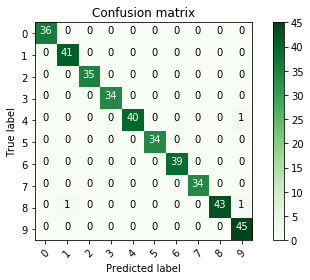

In [127]:
best = svm.SVC(kernel='rbf', C=3.65, gamma=0.1)
X_train, X_test, Y_train, Y_test = split(scaled_v8, .20, 3)

# pca = PCA(.98)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

Y_pred = best.fit(X_train, Y_train).predict(X_test)

def plot_confusion_matrix(cm, classes):
#     print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()

print 'Accuracy', best.score(X_test, Y_test)
plot_confusion_matrix(cnf_matrix, classes=range(0,10))

plt.show()